# Bank marketing use case |  Monkey Patch your machine learning pipeline

## 0. Setup

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from utils import data_prep, model_performance, create_observability_report

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
jan = pd.read_csv('../data/predict/jan-data.csv')
model = pickle.load(open('../models/model_log.cav','rb'))

## 1. Introduction

You are now aware of the potential datastrophes and failures that may happen in your model pipelines in Production. As a data scientist wanting to have more confidence in those pipelines, you have decided to prevent those failures by logging the events of your scripts. 

In this notebook, we will see how a logging library can be included upstream (from the creation of the dataset to the predict of the model) to avoid any `datastrophe` to happen. 

## 2. The data extraction script

The logging strategy wants to prevent any failure when you run the model. To be complete, you need to trace and monitor your dataflow as soon as possible. In the following cell, take a moment to acquaint yourself with the code we will run and log in the exercise. 

In [5]:
customers_info = pd.read_csv('../data/predict/may-customers-data.csv')
contact_info = pd.read_csv('../data/predict/may-contact-data.csv')
business_info = pd.read_csv('../data/predict/may-business-data.csv')

customer360 = customers_info.merge(contact_info,on='id')

may = pd.merge(customer360,business_info)

may.to_csv('../data/predict/may-data.csv',index=False)

## 3. How to log the events of the script?

In this notebook, we will show you how you can simply log all events in the notebook in order to track the lineage and enable AI observability. 

We will use an open source library provided by Kensu. The library will monkey patch the common python libraries such as pandas and sklearn in order to keep records of what happens in the script. With this library, we will be able to extract the following information from the notebook:
- the data sources used and their schemas
- the lineages (also called data flow or data map) among those data sources
- the statistics and metrics of the data sources in that context 

To import the library, you need to add the kensu prefix to the library we need to monkeypatch:

$$\text{pandas} \rightarrow  \text{kensu.pandas}$$

Once imported, you can initialize the client with the `KensuProvider` object. Several parameters are available and you can find the list in the user documentation. 

The `Context` of the application is defined by its `process_name` (an identifier for your application), `project_names`(where the application is running), and `environment`.

In [6]:
from kensu.utils.kensu_provider import KensuProvider
kensu = KensuProvider().initKensu(process_name='Exercise 3',
                            user_name='Sammy', 
                            code_location='https://gitlab.example.com', 
                            init_context=True, 
                            project_names=['O-Reilly'], 
                            environment="Production",
                            report_to_file=True,
                            offline_file_name='log_pandas_example.log')


### Example of a wrapped function:
``` python
def wrap_pandas_get_dummies(method):
    def wrapper(*args, **kwargs):
        kensu = KensuProvider().instance()
        df_result = method(*args, **kwargs)
        df = args[0] # see get_dummies definition (first arg is `data`)

        orig_ds = kensu.extractors.extract_data_source(df)
        orig_sc = kensu.extractors.extract_schema(orig_ds, df)
        result_ds = kensu.extractors.extract_data_source(df_result)
        result_sc = kensu.extractors.extract_schema(result_ds, df_result)

        col_dest = [k.name for k in result_sc.pk.fields]
        col_orig = [k.name for k in orig_sc.pk.fields]
        prefix = kwargs['prefix'] if 'prefix' in kwargs else None
        prefix_sep = kwargs['prefix_sep'] if 'prefix_sep' in kwargs else "_"
        columns = kwargs['columns'] if 'columns' in kwargs else None

        for col in col_dest:
            if col in col_orig:
                kensu.add_dependencies_mapping(result_sc.to_guid(), col, orig_sc.to_guid(), col)
            else:
                origin_col = col.split(prefix_sep)[0]
                if prefix:
                    if isinstance(prefix,list):
                        index = prefix.index(origin_col)
                        origin_col = columns[index]
                kensu.add_dependencies_mapping(result_sc.to_guid(), col, orig_sc.to_guid(), origin_col)

        return df_result

    wrapper.__doc__ = method.__doc__
    return wrapper

get_dummies = wrap_pandas_get_dummies(pd.get_dummies)
```

**Exercise:** Integrate the library in the following code and inspect the result 

- *Note:* the client has been already initialized in the previous cell

In [7]:
#Write your code here

import kensu.pandas as pd

customers_info = pd.read_csv('../data/predict/may-customers-data.csv')
contact_info = pd.read_csv('../data/predict/may-contact-data.csv')
business_info = pd.read_csv('../data/predict/may-business-data.csv')

customer360 = customers_info.merge(contact_info,on='id')
may = pd.merge(customer360,business_info)
may.to_csv('../data/predict/may-data.csv',index=False)

In [8]:
may

,age,job,marital,education,default,housing,loan,id,contact,month,...,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,38,admin.,divorced,university.degree,no,yes,no,35704,cellular,aug,...,92,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
1,33,services,single,basic.6y,unknown,yes,yes,16354,telephone,may,...,19,8,999,1,failure,-1.8,92.893,-46.2,1.281,5099.1
2,40,blue-collar,married,basic.4y,unknown,yes,no,10501,cellular,jul,...,131,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
3,56,blue-collar,married,basic.9y,unknown,no,no,26419,cellular,jul,...,236,8,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
4,56,technician,divorced,basic.9y,no,yes,no,15197,telephone,jun,...,39,8,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8198,59,blue-collar,divorced,basic.4y,no,no,no,12165,telephone,may,...,167,2,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0
8199,29,technician,married,professional.course,no,yes,no,40423,telephone,may,...,35,1,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0
8200,33,self-employed,married,university.degree,no,yes,yes,17800,cellular,nov,...,208,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
8201,75,retired,divorced,basic.4y,no,no,no,40906,cellular,apr,...,227,4,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1


The result of the piece of code you've run is available in the `log_pandas_example.log` file:

In [9]:
!cat log_pandas_example.log

{"action": "add_entity", "entity": "PHYSICAL_LOCATION", "generatedEntityGUID": "empty", "schemaVersion": "0.1", "jsonPayload": {"name": "Unknown", "lat": 0.12341234, "lon": 0.12341234, "pk": {"city": "Unknown", "country": "Unknown"}}, "context": {"clientId": "", "clientEventTimestamp": 1624456662712, "serverReceivedTimestamp": 1624456662712}}
{"action": "add_entity", "entity": "USER", "generatedEntityGUID": "empty", "schemaVersion": "0.1", "jsonPayload": {"pk": {"name": "Sammy"}}, "context": {"clientId": "", "clientEventTimestamp": 1624456662713, "serverReceivedTimestamp": 1624456662713}}
{"action": "add_entity", "entity": "CODE_BASE", "generatedEntityGUID": "empty", "schemaVersion": "0.1", "jsonPayload": {"pk": {"location": "https://gitlab.example.com"}}, "context": {"clientId": "", "clientEventTimestamp": 1624456662713, "serverReceivedTimestamp": 1624456662713}}
{"action": "add_entity", "entity": "CODE_VERSION", "generatedEntityGUID": "empty", "schemaVersion": "0.1", "jsonPayload": {

This file is not easy to understand by itself. Fortunately, the `create_observability_report` function from the utils module will help you to generate documentation based on the log file. 

The function takes 2 arguments, the first one is the `log file` path, and the second is the name of the document with a `.pdf` extention that you want to generate. 

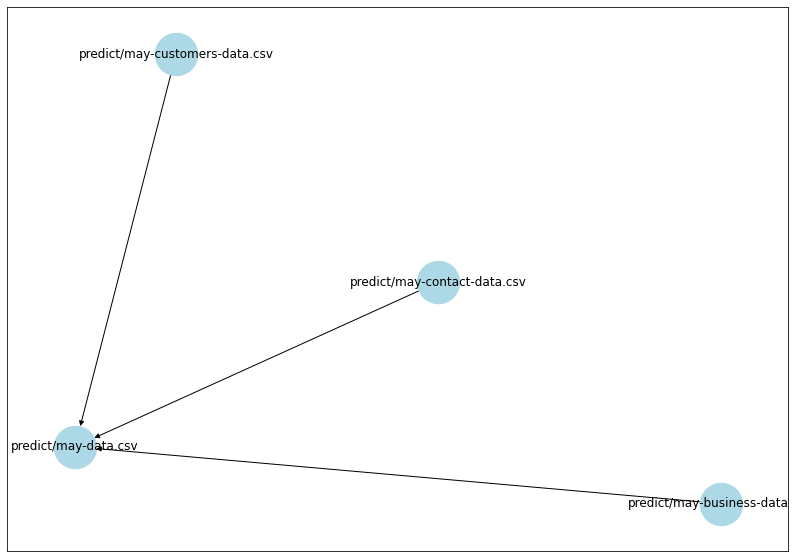

In [10]:
create_observability_report('log_pandas_example.log','Report-example.pdf')

## Well done!

A new observability report is now available in your working directory. Take a moment to explore it. What more would you like to log? 

In the next exercise, we will see how you can activate those reports in order to have SLA and SLO in your AI pipelines.  